## Table of Contents

1. [Introduction](#section-1-introduction)
2. [Why Circular Statistics?](#section-2-why-circular)
3. [Circular Mean and Resultant Vector Length](#section-3-circular-mean)
4. [Visualizing Phase Distributions](#section-4-visualization)
5. [Exercises](#section-5-exercises)
6. [Summary](#summary)
7. [External Resources](#external-resources)
8. [Discussion Questions](#discussion-questions)

---

In [1]:
# =============================================================================
# Imports
# =============================================================================

# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

# Local imports
src_path = Path.cwd().parent.parent.parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from phase import (
    wrap_phase,
    unwrap_phase,
    circular_mean,
    resultant_vector_length,
    circular_variance,
    circular_std,
    plot_phase_polar_histogram,
    plot_phase_on_circle,
)
from colors import COLORS

# Matplotlib configuration
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 11

print(f"NumPy version: {np.__version__}")
print(f"Source path: {src_path}")

NumPy version: 2.3.5
Source path: /Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials/src


---

<a id="section-1-introduction"></a>
## 1. Introduction

Phase values are **circular** - they wrap around at ±π. This circular nature breaks standard (linear) statistics:

| Problem | Linear Statistics | Circular Statistics |
|---------|------------------|--------------------|
| Mean of -170° and +170° | 0° ❌ | ±180° ✓ |
| Standard deviation | Can exceed 360° | Bounded [0, √2] |
| Distance metric | Ignores wrap | Respects circular nature |

This notebook introduces the **circular statistics** needed for phase-based connectivity metrics like PLV.

---

<a id="section-2-why-circular"></a>
## 2. Why Circular Statistics?

The key insight: phases are **unit vectors**, not numbers on a line.

Two phases: -170° and +170°

Linear mean: 0.0° ❌ (wrong - opposite side!)
Circular mean: 180.0° ✓ (correct - between the phases)


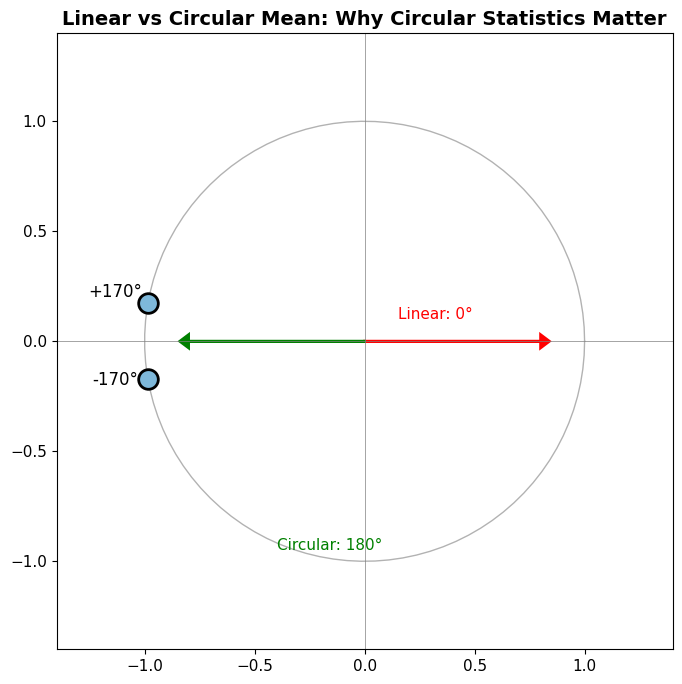

In [2]:
# =============================================================================
# Demo: Linear vs Circular Mean
# =============================================================================

# Two phases near the wrap point
phase1 = np.radians(-170)  # Close to -π
phase2 = np.radians(170)   # Close to +π
phases = np.array([phase1, phase2])

# Calculate both means
linear_mean = np.mean(phases)
circ_mean = circular_mean(phases)

print("Two phases: -170° and +170°")
print(f"\nLinear mean: {np.degrees(linear_mean):.1f}° ❌ (wrong - opposite side!)")
print(f"Circular mean: {np.degrees(circ_mean):.1f}° ✓ (correct - between the phases)")

# Visualize on unit circle
fig, ax = plt.subplots(figsize=(8, 8))

# Draw unit circle
theta = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k-', linewidth=1, alpha=0.3)
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)

# Plot phases
for ph, label in [(phase1, '-170°'), (phase2, '+170°')]:
    ax.scatter(np.cos(ph), np.sin(ph), s=200, c=COLORS["signal_1"], 
               edgecolors='black', linewidths=2, zorder=5)
    ax.annotate(label, (np.cos(ph)*1.15, np.sin(ph)*1.15), fontsize=12, ha='center')

# Plot linear mean (WRONG)
ax.arrow(0, 0, np.cos(linear_mean)*0.8, np.sin(linear_mean)*0.8,
         head_width=0.06, head_length=0.04, fc='red', ec='red', linewidth=2)
ax.text(0.15, 0.1, f'Linear: {np.degrees(linear_mean):.0f}°', color='red', fontsize=11)

# Plot circular mean (CORRECT)
ax.arrow(0, 0, np.cos(circ_mean)*0.8, np.sin(circ_mean)*0.8,
         head_width=0.06, head_length=0.04, fc='green', ec='green', linewidth=2)
ax.text(-0.4, -0.95, f'Circular: {np.degrees(circ_mean):.0f}°', color='green', fontsize=11)

ax.set_xlim(-1.4, 1.4)
ax.set_ylim(-1.4, 1.4)
ax.set_aspect('equal')
ax.set_title('Linear vs Circular Mean: Why Circular Statistics Matter', fontsize=14, fontweight='bold')
plt.show()

---

<a id="section-3-circular-mean"></a>
## 3. Circular Mean and Resultant Vector Length

### The Vector Averaging Method

1. Convert each phase to a unit vector: $e^{i\theta}$
2. Average the vectors: $\bar{z} = \frac{1}{N}\sum e^{i\theta_k}$
3. **Circular mean** = direction of $\bar{z}$
4. **Resultant Vector Length (R)** = magnitude of $\bar{z}$

| R Value | Interpretation |
|---------|---------------|
| R = 1 | All phases identical |
| R ≈ 0.7-0.9 | Highly concentrated |
| R ≈ 0 | Uniformly distributed |

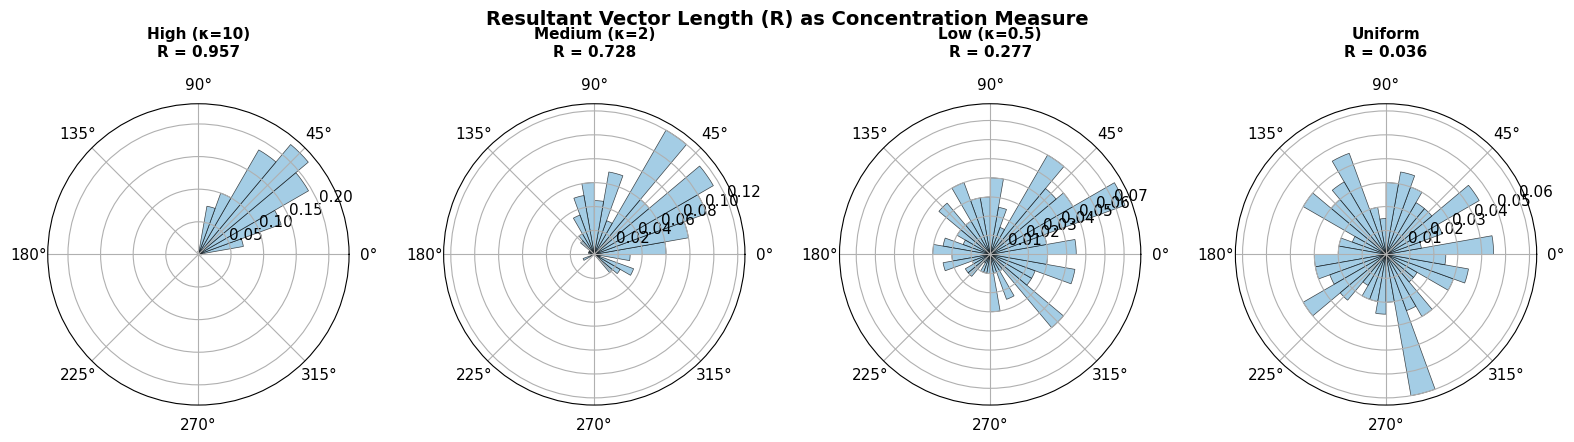


📊 Key Insight: R measures how clustered phases are around their mean
   This is EXACTLY what PLV measures for phase differences!


In [3]:
# =============================================================================
# R for Different Phase Distributions
# =============================================================================

np.random.seed(42)

# Create distributions with different concentrations (von Mises)
distributions = [
    ('High (κ=10)', np.random.vonmises(mu=np.pi/4, kappa=10, size=200)),
    ('Medium (κ=2)', np.random.vonmises(mu=np.pi/4, kappa=2, size=200)),
    ('Low (κ=0.5)', np.random.vonmises(mu=np.pi/4, kappa=0.5, size=200)),
    ('Uniform', np.random.uniform(-np.pi, np.pi, size=200)),
]

fig, axes = plt.subplots(1, 4, figsize=(16, 4), subplot_kw=dict(projection='polar'))

for ax, (name, phases) in zip(axes, distributions):
    R = resultant_vector_length(phases)
    V = circular_variance(phases)
    
    plot_phase_polar_histogram(phases, ax=ax, color=COLORS["signal_1"], n_bins=36)
    ax.set_title(f'{name}\nR = {R:.3f}', fontsize=11, fontweight='bold', pad=15)

plt.tight_layout()
plt.suptitle('Resultant Vector Length (R) as Concentration Measure', fontsize=14, fontweight='bold', y=1.05)
plt.show()

print("\n📊 Key Insight: R measures how clustered phases are around their mean")
print("   This is EXACTLY what PLV measures for phase differences!")

---

<a id="section-4-visualization"></a>
## 4. Visualizing Phase Distributions

Three common visualization methods for circular data.

AttributeError: 'Axes' object has no attribute 'set_theta_zero_location'

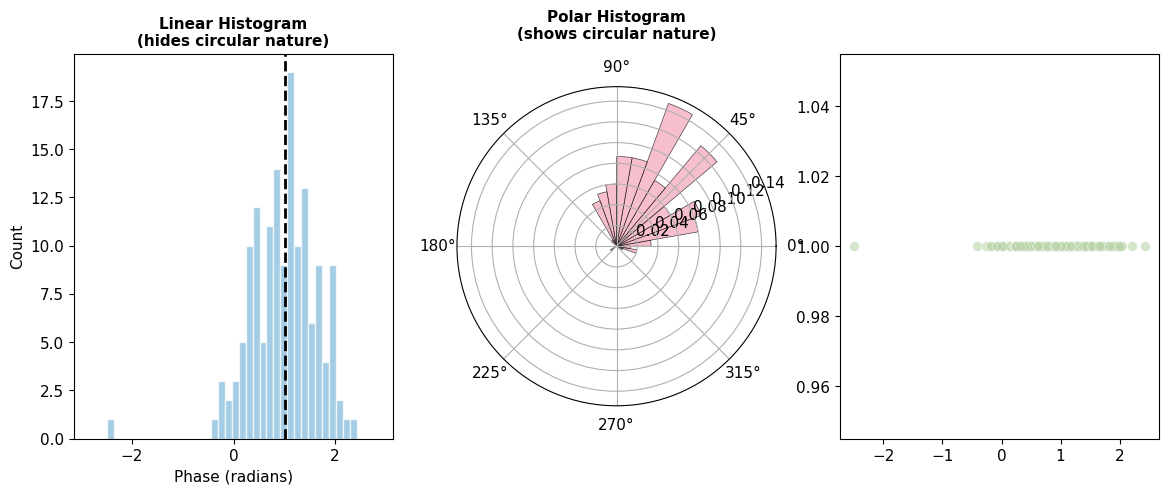

In [4]:
# =============================================================================
# Comparing Visualization Methods
# =============================================================================

np.random.seed(42)
phases = np.random.vonmises(mu=np.pi/3, kappa=3, size=150)

fig = plt.figure(figsize=(14, 5))

# Method 1: Linear histogram
ax1 = fig.add_subplot(1, 3, 1)
ax1.hist(phases, bins=36, color=COLORS["signal_1"], alpha=0.7, edgecolor='white')
ax1.axvline(circular_mean(phases), color='black', linestyle='--', linewidth=2)
ax1.set_xlabel('Phase (radians)')
ax1.set_ylabel('Count')
ax1.set_title('Linear Histogram\n(hides circular nature)', fontsize=11, fontweight='bold')
ax1.set_xlim(-np.pi, np.pi)

# Method 2: Polar histogram
ax2 = fig.add_subplot(1, 3, 2, projection='polar')
plot_phase_polar_histogram(phases, ax=ax2, color=COLORS["signal_2"], n_bins=36)
ax2.set_title('Polar Histogram\n(shows circular nature)', fontsize=11, fontweight='bold', pad=15)

# Method 3: Unit circle
ax3 = fig.add_subplot(1, 3, 3)
plot_phase_on_circle(phases, ax=ax3, color=COLORS["signal_3"], show_mean=True)
ax3.set_title(f'Unit Circle\nR = {resultant_vector_length(phases):.3f}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

---

<a id="section-5-exercises"></a>
## 5. Exercises

### 🎯 Exercise 1: Linear vs Circular Mean

**Task:** Create phases at -160°, -170°, +170°, +160° and compare linear vs circular mean.

```python
# Your code here
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
phases = np.radians([-160, -170, 170, 160])
print(f"Linear mean: {np.degrees(np.mean(phases)):.1f}°")
print(f"Circular mean: {np.degrees(circular_mean(phases)):.1f}°")
```

</details>

### 🎯 Exercise 2: R and Concentration

**Task:** Generate phases with different κ values (0.1, 1, 5, 20) and plot R vs κ.

```python
# Your code here
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
kappas = [0.1, 1, 5, 20]
Rs = [resultant_vector_length(np.random.vonmises(0, k, 500)) for k in kappas]
plt.plot(kappas, Rs, 'o-')
plt.xlabel('κ (concentration)')
plt.ylabel('R')
plt.show()
```

</details>

---

<a id="summary"></a>
## 6. Summary

### Key Concepts

| Concept | Formula | Range |
|---------|---------|-------|
| **Circular mean** | $\bar{\theta} = \arctan2(\sum\sin\theta, \sum\cos\theta)$ | $[-\pi, \pi]$ |
| **Resultant Vector Length (R)** | $R = \|\frac{1}{n}\sum e^{i\theta}\|$ | $[0, 1]$ |
| **Circular variance** | $V = 1 - R$ | $[0, 1]$ |

### Functions from `src/phase.py`

```python
from phase import (
    wrap_phase,                # Wrap to [-π, π]
    unwrap_phase,              # Remove discontinuities
    circular_mean,             # Average direction
    resultant_vector_length,   # Concentration (R)
    circular_variance,         # Dispersion (1 - R)
    circular_std,              # Circular standard deviation
    plot_phase_polar_histogram,
    plot_phase_on_circle,
)
```

### Key Insight

> **R applied to phase differences = PLV (Phase Locking Value)**

---

<a id="external-resources"></a>
## 7. External Resources

### 📚 Scientific References

- **Fisher, N.I. (1993)** - *Statistical Analysis of Circular Data*
- **Mardia, K.V. & Jupp, P.E. (2000)** - *Directional Statistics*

### 🎧 NotebookLM Resources

- [📺 Video Overview](https://notebooklm.google.com/notebook/cb53f20f-a599-4681-8f6a-28a958412045?artifactId=a6291909-f06a-4d58-bcf8-b43d8e64f807) - Video overview of circular statistics concepts
- [📝 Quiz](https://notebooklm.google.com/notebook/cb53f20f-a599-4681-8f6a-28a958412045?artifactId=1fea7300-96d6-4927-b8b2-fa869923d329) - Test your understanding of circular statistics
- [🗂️ Flashcards](https://notebooklm.google.com/notebook/cb53f20f-a599-4681-8f6a-28a958412045?artifactId=701d29f6-dc10-41bb-935f-9a0e1d66a057) - Review key concepts

---

<a id="discussion-questions"></a>
## 8. Discussion Questions

1. **Why can't we use `np.mean()` for phase?** Give a concrete example where it fails.

2. **R as synchronization measure**: In hyperscanning, what would R = 0.1 vs R = 0.9 mean for two participants' brain signals?

3. **From R to PLV**: Based on what you learned about R, how would you measure synchronization between two signals?

---

**Next:** [B02b: Phase Relationships](B02b_phase_relationships.ipynb)